<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/Cantileaver_Shaft_speed_reducer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem statement**

**Tip displacement equation** (Loads, Material, and Geometry play a role)

The displacement of the beam tip can be computed as follows:

$$
f(x;\theta) = \frac{4L^3}{E w t} \sqrt{\left(\frac{P_y }{t^2}\right)^2 +\left(\frac{P_x}{w^2}\right)^2}*italicised text*
$$

**Cost of the beam**  (Only proportional to geometry, i.e., volume)

$$
C(\theta) =  L \times w  \times t
$$


**Parameters**:

- $L = 100 $ [inces] is the length of the beam,
- $w = 2 $  [inces] and is the width of the cross section,
- $t = 4 $ [inces] is the height of the cross section,   
- $D_0 = 3 $ [inces] is the maximum allowable tip displacement.


**Uncertainties**
$$ x = (P_x,P_y) \sim \mathcal{N}(\mu, \Sigma)$$

- $P_x \sim N(500, 100) $ [lb] is the normal distribution of the external force in the x-direction,
- $P_y \sim N(1000, 100) $ [lb] is the normal distribution of the external force in the y-direction,

- $ E = 30 \times 10^6 $ [psi] is the modulus of elasticity and it is uncertain/imprecise up to a tollerance imprecision of $\pm 10^5 $ [psi]


**Tasks**
1. Define a sampler for the uncertain factors.

2. Define the performance function g(x) and estimate the probability of failure using Monte Carlo.

3. Visualize failure and safe region in the space $(P_x, P_y)$.

4. Repeat the analysis for allowable displacements $D_0 \in [4,2]$. Visualize the results.


5. Can we do better? Explore different $(w,t)$ around the design point. Compute costs and reliability.

6. Now assume a correlation coefficient $\rho({P_x,P_y})=0.7 $ due to correlated wind. Repeat the analysis for a design point $(w,t)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def g_fun_beam_displacement(Px, Py, theta=None):
    # Define performance function (g function)
    E = 30e6  # Modulus of elasticity (psi)
    if theta is None:
      w = 2     # Nominal Width of the cross section (inches)
      t = 4     # Nominal Height of the cross section (inches)
      L = 100   # Length of the beam (inches)
    else:
      w, t = theta[0], theta[1]
      L = 100   # Length of the beam (inches)
    D0 = 3    # Allowable tip displacement (inches)

    displacement = (4 * L**3) / (E * w * t) * np.sqrt((Py / t**2)**2 + (Px / w**2)**2)  # Displacement formula from the given equation
    return D0 - displacement  # Performance function g(D)

# External forces Px and Py with normal distributions
mean_Px = 500  # Mean of Px (lb)
std_Px = 100   # Standard deviation of Px (lb)

mean_Py = 1000 # Mean of Py (lb)
std_Py = 100   # Standard deviation of Py (lb)

# Px and Py are normally distributed and uncorrelated
# Generate random samples of Px and Py from normal distributions
num_samples = 200_000  # Number of samples for Monte Carlo simulation
Px_samples = np.random.normal(mean_Px, std_Px, num_samples)
Py_samples = np.random.normal(mean_Py, std_Py, num_samples)


# Compute the performance function for each sample
g_values = g_fun_beam_displacement(Px=Px_samples, Py=Py_samples,theta=None)
I_sams = g_values<=0

# Calculate probability of failure (g(D) <= 0)
failure_probability_MC = np.mean(g_values <= 0)
print(f'Estimated Probability of Failure: {failure_probability_MC:.4f}')
print(f'Estimated Reliability: {1-failure_probability_MC:.4f}')


Estimated Probability of Failure: 0.0406
Estimated Reliability: 0.9594


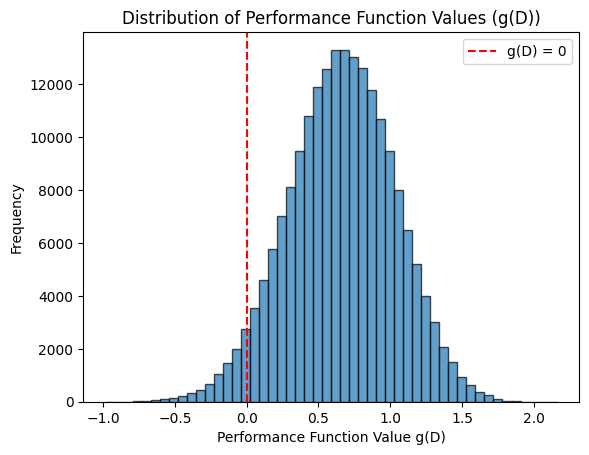

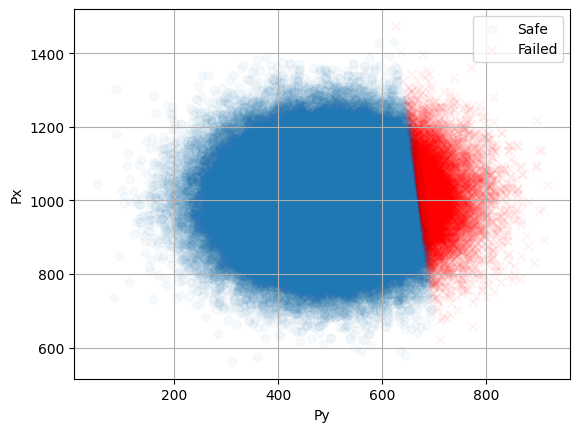

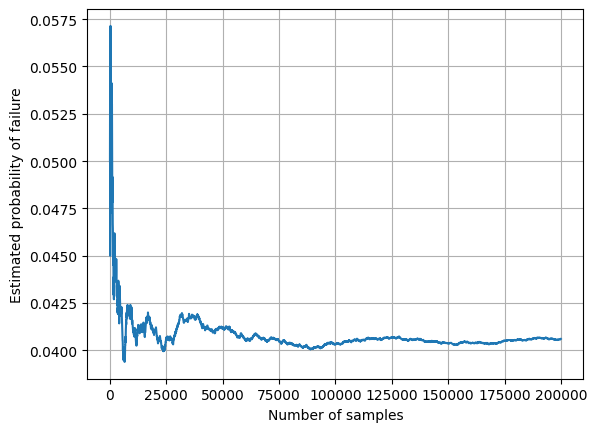

In [3]:
# Plotting the results (distribution of performance function values)
plt.hist(g_values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label="g(D) = 0")
plt.xlabel('Performance Function Value g(D)')
plt.ylabel('Frequency')
plt.title('Distribution of Performance Function Values (g(D))')
plt.legend()
plt.show()

# Visualization of failure region

plt.scatter(Px_samples[I_sams==0], Py_samples[I_sams==0], alpha=0.03, label=f"Safe")
plt.scatter(Px_samples[I_sams==1], Py_samples[I_sams==1], alpha=0.05, c='r', marker='x', label="Failed")
plt.xlabel('Py')
plt.ylabel('Px')
plt.legend()
plt.grid()
plt.show()

# Convergence of the estimator
steps_2_eval = range(100,len(I_sams),50)
Pf_step_k = np.array([np.mean(I_sams[:k]) for k in steps_2_eval])
plt.plot(steps_2_eval, Pf_step_k)
plt.xlabel('Number of samples')
plt.ylabel('Estimated probability of failure')
plt.grid()
plt.show()

In [4]:
import scipy.stats as stats
from scipy.linalg import cholesky


def generalized_nataf_transform(X, marginals, corr_matrix):
    """  Generalized Nataf Transformation   """
    n_samples, n_dim = X.shape
    # Step 1: Transform to uniform space via marginal CDFs
    W = np.zeros_like(X)
    for i in range(n_dim):
        W[:, i] = marginals[i].cdf(X[:, i])  # T1: X → W (uniform space)

    # Step 2: Transform to elliptical space via inverse CDF of standard elliptical distribution
    V = stats.norm.ppf(W)  # T2: W → V (Gaussian space)

    # Step 3: Transform to standard space using Cholesky decomposition of the correlation matrix
    Gamma = np.linalg.inv(cholesky(corr_matrix, lower=True))  # T: X → U (to the standard space U~N(0,1) )
    U = V @ Gamma.T
    return U

def inverse_nataf_transform(u, marginals, corr_matrix):
    """  Invert the Nataf transformation to map U back to X. """
    n_samples, n_dim = u.shape
    x = np.zeros_like(u)

    # Step 1: Generate correlated standard normal variables U
    L = cholesky(corr_matrix, lower=True)  # Cholesky factor of the correlation matrix
    u_correlated = u @ L.T  # Impose correlation structure

    # Step 2: Map U to X using the inverse CDFs
    for i in range(n_dim):
        x[:, i] = marginals[i].ppf(stats.norm.cdf(u_correlated[:, i]))

    return x

In [5]:
# FORM (First-Order Reliability Method)
from scipy.optimize import minimize
from scipy.stats import norm

g_fun = lambda x: g_fun_beam_displacement(Px=x[:,0], Py=x[:,1], theta=None)

def constraint(u, g_fun, marginals, corr_matrix):
    """
    Constraint function g(u) = 0,
    Args:
        u: A numpy array of shape (n_dim,) containing the variables in U-space.
        marginals: A list of scipy.stats distribution objects corresponding to the marginals of X.
        corr_matrix: The correlation matrix of X.
    Returns:
        Value of the constraint function g(x).
    """
    u = u.reshape(1, -1)  # Reshape u to (1, n_dim) for compatibility with inverse_nataf_transform
    x = inverse_nataf_transform(u, marginals, corr_matrix)  # Invert the Nataf transformation to get x
    return g_fun(x)  # Evaluate the performance function g(x)

# Find the Most Probable Point (MPP) in U-space
def find_mpp(g_fun, marginals, corr_matrix):
    """
    Find the Most Probable Point (MPP) in U-space.
    Args:
        marginals: A list of scipy.stats distribution objects corresponding to the marginals of X.
        corr_matrix: The correlation matrix of X.
    Returns:
        u_mpp: MPP in U-space.
    """

    def objective(u):   # Objective function: Minimize the distance to the origin
        return np.linalg.norm(u)

    def constraint_function(u):  # Constraint: g(u) = 0
        return constraint(u, g_fun, marginals, corr_matrix)

    u0 = np.array([0, 0])   # Initial guess (origin in U-space)

    # Solve the optimization problem
    result = minimize(objective, u0, constraints={'type': 'eq', 'fun': constraint_function})
    return result.x


In [6]:
# Find the MPP
marginals = [norm(mean_Px, std_Px), norm(mean_Py, std_Py)]
corr_matrix = np.array([[1.0, 0], [0, 1.0]])

u_mpp = find_mpp(g_fun, marginals, corr_matrix)

# Step 4: Compute the reliability index beta
beta = np.linalg.norm(u_mpp)

# Step 5: Compute the probability of failure using FORM
pf_form = stats.norm.cdf(-beta)
rel_form =  1- pf_form

# Print results

print("\n-------- Monte Carlo:----------")
print(f"Monte Carlo Estimate of P[g(x) <= 0]: {failure_probability_MC:.6f}")
print(f"Monte Carlo Estimate of P[g(x) > 0]: {1 - failure_probability_MC:.6f}")
print("\n-----------------------------------")

print("\n-------- FORM:----------")
print(f"Probability of failure FORM (P_f): {pf_form:.6f}")
print(f"Reliability FORM (1-P_f): {rel_form:.6f}")
print("\n-----------------------------------")
print(f"Most Probable Point (MPP) in U-space: {u_mpp}")
print(f"Reliability index (β): {beta:.4f}")



-------- Monte Carlo:----------
Monte Carlo Estimate of P[g(x) <= 0]: 0.040610
Monte Carlo Estimate of P[g(x) > 0]: 0.959390

-----------------------------------

-------- FORM:----------
Probability of failure FORM (P_f): 0.040541
Reliability FORM (1-P_f): 0.959459

-----------------------------------
Most Probable Point (MPP) in U-space: [1.73673769 0.16375407]
Reliability index (β): 1.7444


Monte Carlo Estimate of P[g(x) <= 0]: 2e-06
Monte Carlo Estimate of P[g(x) > 0]: 0.999998


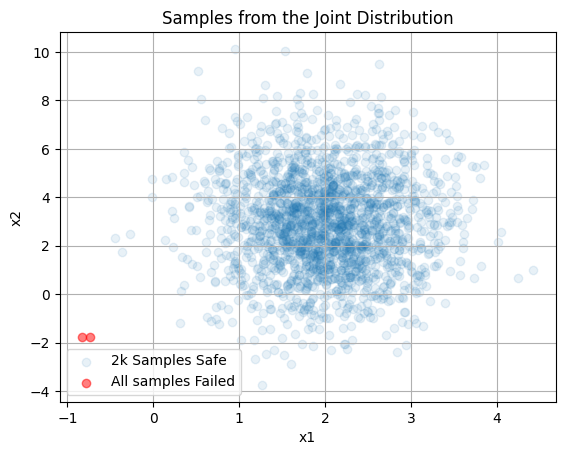

In [9]:
# Problem 2:
def g_fun_prob2(x1, x2, params=None):
    if params is None:
        params = [1, 1]
    return (x1 + 3 + params[1] * params[0])**2 + params[0] * 3 * (x2 + 2)**2 - 12

# Define the Indicator Function I(x)
def I_fun(x1, x2):
    return g_fun_prob2(x1, x2) <= 0

# Define the Joint Probability Distribution f(x1, x2)
# Define distribution parameters
mu_x1, mu_x2 = 2, 3
sigma_x1, sigma_x2 = 0.7, 2

# Define normal distribution objects
f_x1 = stats.norm(loc=mu_x1, scale=sigma_x1)
f_x2 = stats.norm(loc=mu_x2, scale=sigma_x2)

# Monte Carlo Estimation
sample_size = 1_000_000
samples_x1 = f_x1.rvs(size=sample_size)
samples_x2 = f_x2.rvs(size=sample_size)
I_sams = I_fun(samples_x1, samples_x2)
mc_estimate_pof = np.mean(I_sams)

print(f"Monte Carlo Estimate of P[g(x) <= 0]: {mc_estimate_pof}")
print(f"Monte Carlo Estimate of P[g(x) > 0]: {1- mc_estimate_pof}")

# Visualization
n2p = 2
plt.scatter(samples_x1[:n2p*1000], samples_x2[:n2p*1000], alpha=0.1, label=f"{n2p}k Samples Safe")
plt.scatter(samples_x1[I_sams==1], samples_x2[I_sams==1], alpha=0.5, c='r', label="All samples Failed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Samples from the Joint Distribution')
plt.legend()
plt.grid()
plt.show()

In [15]:
## OMPLETE PROBABILISTIC ASSESSMENT USING FORM, FIND MPP

def constraint(u, g_fun, marginals):
    """
      Now let us prepare the constriant (s.t g(u)=0)
    """
    # Complete Code

    # Transform u back to physial space x
    # x are uncorrelated Gaussian, so it is quite fine to apply....


    # Evaluate the performance function g_fun(x)


# Find the Most Probable Point (MPP) in U-space
def find_mpp_prop2(g_fun, marginals):
    """
    Find the Most Probable Point (MPP) in U-space.
    """
    # Objective function: Minimize the distance to the origin
    # add your code for the objective function here...

    # Constraint function g(u) = 0
    # add your code for the constraint function here

    # Initial guess (origin in U-space)
    u0 = []

    # Solve the optimization problem....get solution and reliability index beta
    x_optim, beta = [np.inf,np.inf], np.inf # replace with optimization

    return x_optim, beta


# FORM (First-Order Reliability Method)
g_fun = lambda x: g_fun_prob2(x[:,0], x[:,1])
u_mpp, beta = find_mpp_prop2(g_fun, marginals)


# Step 5: Compute the probability of failure using FORM
pf_form = stats.norm.cdf(-beta)
rel_form = 1-pf_form
# Print results
print("FORM Results:")
print(f"Most Probable Point (MPP) in U-space: {u_mpp}")
print(f"Reliability index (β): {beta:.4f}")
print(f"Probability of failure FORM (P_f): {pf_form:.6f}")
print(f"Reliability FORM (1-P_f): {rel_form:.6f}")

print("\nMonte Carlo Results:")
print(f"Monte Carlo Estimate of P[g(x) <= 0]: {mc_estimate_pof:.6f}")
print(f"Monte Carlo Estimate of P[g(x) > 0]: {1 - mc_estimate_pof:.6f}")

FORM Results:
Most Probable Point (MPP) in U-space: [inf, inf]
Reliability index (β): inf
Probability of failure FORM (P_f): 0.000000
Reliability FORM (1-P_f): 1.000000

Monte Carlo Results:
Monte Carlo Estimate of P[g(x) <= 0]: 0.000002
Monte Carlo Estimate of P[g(x) > 0]: 0.999998


# Investigate this shaft speed reducer.

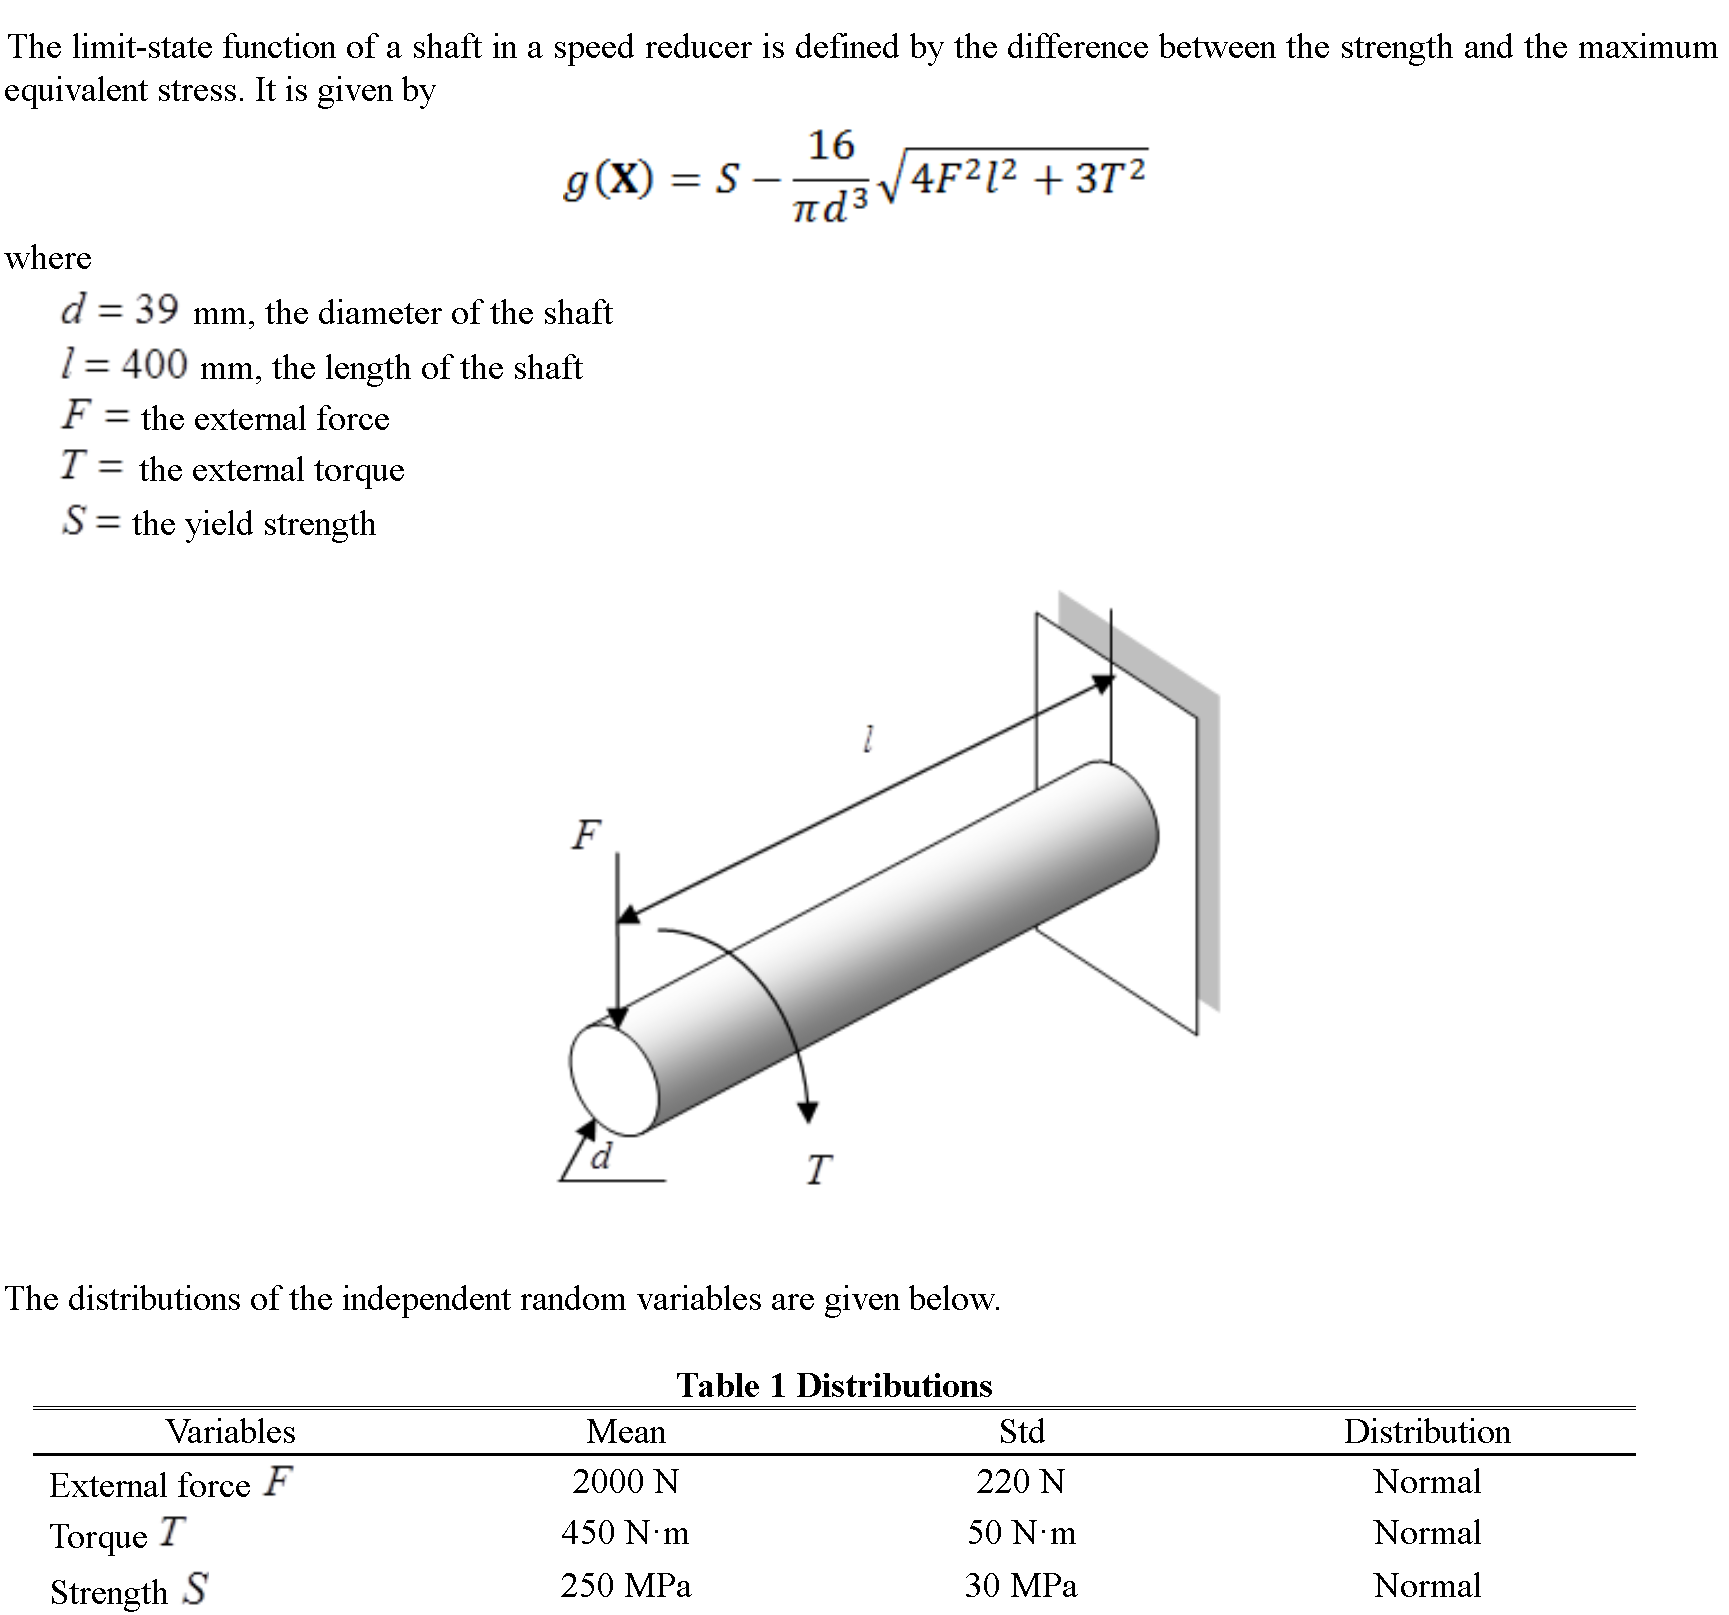

In [ ]:
# This is the problem